In [85]:
import torch
import torch.nn as nn 
import pandas as pd
import numpy as np
import time
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import datetime

In [86]:
from src.algorithms.vae import VaeAlgo
from src.utils.util import *
from src.dataset.Nabdataset import NabDataset
from src.model.modelvae import *

In [87]:
#This is the beginning of programm
t = time.localtime()
current_time = time.strftime("%H:%M:%S", t)
print(current_time)

01:47:03


<h4>Initializing Dataset</h4>

In [88]:
class ArgsTrn:
    workers=4
    batch_size=32
    epochs=5
    lr=0.0002
    cuda = True
    manualSeed=2
    mean=0
    std=0.1
    
opt_trn=ArgsTrn()
torch.manual_seed(opt_trn.manualSeed)



class Datasettings:
    
    def __init__(self):
        end_name='ambient_temperature_system_failure.csv'
        self.data_folder_path="/home/jupyter//GRANOGAN-IISC/data/nab/"
        key='realKnownCause/'+end_name 
        self.label_file = './lables/combined_windows.json'
        self.key=key
        self.train=True
        self.window_length=60

In [89]:
data_settings = Datasettings()
dataset = NabDataset(data_settings=data_settings)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=opt_trn.batch_size,
                                         shuffle=True, num_workers=int(opt_trn.workers))
seq_len = dataset.window_length # sequence length is equal to the window length
in_dim = dataset.n_feature # input dimension is same as number of feature
n_features=dataset.x.shape[2]
sequences=[x for i, (x,y) in enumerate(dataloader, 0)]

In [90]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [91]:
dataset.x.shape
embedding_dim=16

In [92]:
vaeAlgo=VaeAlgo(device=device,opt_trn=opt_trn,windows_length=seq_len,n_features=n_features,embedding_dim=embedding_dim)

In [93]:
trained_model=vaeAlgo.train_vaeautoencoder(sequences)

/libraries/Default_env_55311/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch 0: train loss 0.5768251253172682
Epoch 1: train loss 0.21620229749109945
Epoch 2: train loss 0.1485311476321056
Epoch 3: train loss 0.12964491549824259
Epoch 4: train loss 0.12006751036849515


In [94]:
PATH='/home/jupyter/src/saved_models/vae/nab/vae.pkl'

In [95]:
torch.save(trained_model.module.state_dict(), PATH)

In [96]:
state_dict = torch.load(PATH)
trained_model=VAE(embedding_dim, n_features,device=device)
trained_model=nn.DataParallel(trained_model)
trained_model.to(device)
trained_model=vaeAlgo.load_model(state_dict,trained_model)

<h4>Loading back the saved models</h4>

In [97]:
vaeAlgo.intialize_lstmvaeautoencoder(trained_model)

<h2>Test Data</h2>


In [98]:
class ArgsTest:
    workers = 1
    batch_size = 1
    
opt_test=ArgsTest()



class TestDataSettings:
    
    def __init__(self):
        end_name='ambient_temperature_system_failure.csv'
        self.data_folder_path="/home/jupyter//GRANOGAN-IISC/data/nab/"
        key='realKnownCause/'+end_name 
        self.label_file = './lables/combined_windows.json'
        self.key=key
        self.train=False
        self.window_length=60        
        
test_data_settings = TestDataSettings()

In [99]:
# define dataset object and data loader object in evaluation mood for NAB dataset
from mlutils import dataset
test_dataset = NabDataset(test_data_settings)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=opt_test.batch_size, 
                                         shuffle=False, num_workers=int(opt_test.workers))

test_dataset.x.shape, test_dataset.y.shape, test_dataset.data_len # check the dataset shape


test_sequences=[x for i, (x,y) in enumerate(test_dataloader, 0)]

In [100]:
losses=vaeAlgo.predict_loss(test_sequences)

/libraries/Default_env_55311/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [101]:
import matplotlib.pyplot as plt
import seaborn as sns

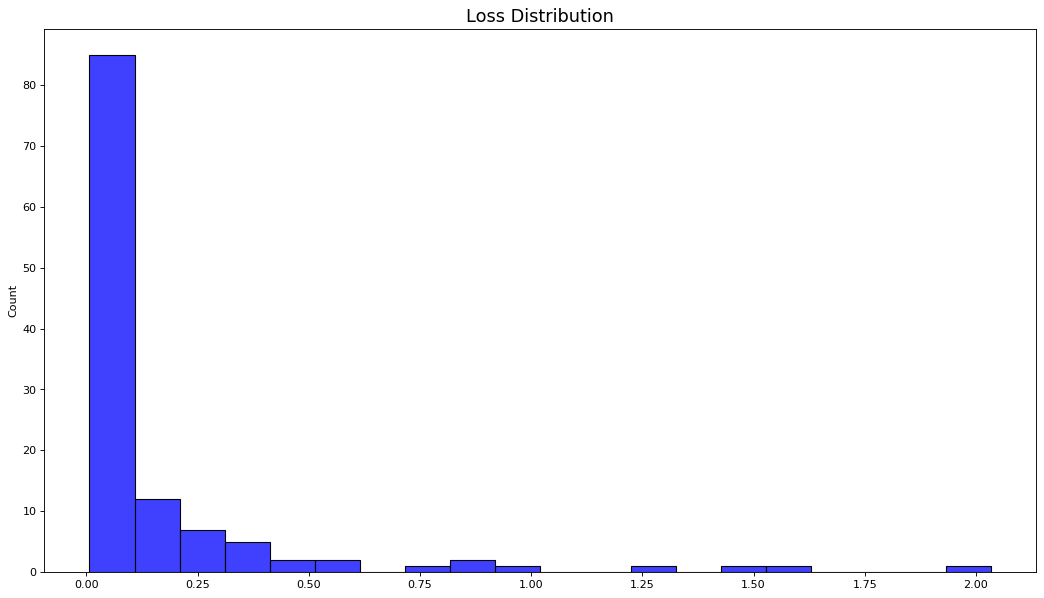

In [102]:
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.histplot(losses, bins = 20, kde= False, color = 'blue');
#sns.distplot(losses, bins = 20, kde= True, color = 'blue');

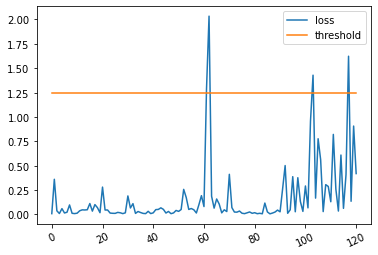

In [106]:
THRESHOLD =1.25

test_score_df = pd.DataFrame(index=range(len(losses)))
test_score_df['loss'] = [loss for loss in losses]
test_score_df['y'] = test_dataset.y
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['t'] = [x[59].item() for x in test_dataset.x]

plt.plot( test_score_df.loss, label='loss')
plt.plot( test_score_df.threshold, label='threshold')
#plt.plot( test_score_df.y, label='y')
plt.xticks(rotation=25)
plt.legend();

In [107]:
import numpy as np
actual,predicted=improve_detection(test_score_df)

In [108]:

from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

predicted = np.array(predicted)
actual = np.array(actual)

print_scores(predicted,actual)

True Positive	 15
True Negative	 103
False Positive	 3
False Negative	 0
Accuracy	 0.9752066115702479
Precision	 0.8333333333333334
Recall	 1.0
f-measure	 0.9090909090909091
cohen_kappa_score	 0.894874022589053
auc	 0.9858490566037736
roc_auc	 0.9858490566037736
